# Import Required Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import config
from tqdm import tqdm
from myloss import myLoss
from sigdatasets import myDatasetNew
import ucds
import random
import models.NeuMF as NeuMF

# Define Basic Configurations

In [13]:
def set_seed(seed):
    """设置全局随机种子以保证实验可复现性"""
    random.seed(seed)          # 设置Python内置random模块的种子
    np.random.seed(seed)       # 设置NumPy的随机种子
    torch.manual_seed(seed)    # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed(seed)  # 设置PyTorch的当前GPU随机种子
    torch.backends.cudnn.deterministic = True  # 启用CuDNN确定性模式
    torch.backends.cudnn.benchmark = False     # 禁用CuDNN自动优化

SPLIT = "=" * 60  # 生成由60个等号组成的分隔字符串
L2 = 1e-5         # 定义L2正则化系数（默认值0.00001）

# Define Training Functions and Result Logging

In [14]:
# 记录原始模型和公平模型的自定义损失值
original_my_loss_values = []  # 存储原始模型每个epoch的自定义损失值
fair_my_loss_values = []      # 存储公平模型每个epoch的自定义损失值
# 训练函数（InUCDS算法）
def train_InUCDS(epoch):
    # 初始化损失记录列表
    original_loss_list = [[], [], []]   # 原始模型: [总损失, BCE损失, 自定义损失]
    fair_loss_list = [[], [], []]       # 公平模型: [总损失, BCE损失, 自定义损失]
    # 使用tqdm创建进度条，遍历数据生成器
    for batch_idx, data in tqdm(enumerate(sample_generator)):
        # 将数据移动到指定设备（如GPU）
        users, items, rating = data[0].to(device), data[1].to(device), data[2].to(device)
        # 设置模型为训练模式
        model_original.train()
        model_fair.train()
        # 清空模型梯度
        original_model_opt.zero_grad()
        fair_model_opt.zero_grad()
        # ----------------------------------------------------
        # 训练原始模型
        # ----------------------------------------------------
        original_model_predict = model_original(users, items)  # 原始模型预测
        # 计算原始模型的二元交叉熵损失
        original_model_bce_loss = bce_loss(original_model_predict.view(-1), rating)
        # 获取原始模型的不活跃用户嵌入和邻居用户嵌入
        inactive_embedding_samples_original = model_original.inactive_embeddings_for_my_loss(samples)
        neighbor_embedding_samples_original = model_original.neighbor_embeddings_for_my_loss(samples)
        # 计算原始模型的自定义损失（如公平性损失）
        original_model_my_loss = my_loss(inactive_embedding_samples_original, neighbor_embedding_samples_original)
        # 原始模型总损失（当前仅包含BCE损失）
        original_model_loss = original_model_bce_loss
        # 记录原始模型的各项损失
        original_loss_list[0].append(original_model_loss.item())        # 总损失
        original_loss_list[1].append(original_model_bce_loss.item())    # BCE损失
        original_loss_list[2].append(original_model_my_loss.item())     # 自定义损失
        # 反向传播并更新原始模型参数
        original_model_loss.backward()
        original_model_opt.step()
        # ----------------------------------------------------
        # 训练公平模型
        # ----------------------------------------------------
        fair_model_predict = model_fair(users, items)  # 公平模型预测
        fair_model_bce_loss = bce_loss(fair_model_predict.view(-1), rating)  # 计算BCE损失
        # 获取公平模型的不活跃用户嵌入和邻居用户嵌入
        inactive_embedding_samples = model_fair.inactive_embeddings_for_my_loss(samples)
        neighbor_embedding_samples = model_fair.neighbor_embeddings_for_my_loss(samples)
        # 计算公平模型的自定义损失（如公平性损失）
        fair_model_my_loss = my_loss(inactive_embedding_samples, neighbor_embedding_samples)
        # 公平模型总损失 = BCE损失 + 自定义损失
        fair_model_loss = fair_model_bce_loss + fair_model_my_loss
        # 记录公平模型的各项损失
        fair_loss_list[0].append(fair_model_loss.item())        # 总损失
        fair_loss_list[1].append(fair_model_bce_loss.item())    # BCE损失
        fair_loss_list[2].append(fair_model_my_loss.item())     # 自定义损失
        # 反向传播并更新公平模型参数
        fair_model_loss.backward()
        fair_model_opt.step()
    # 打印本轮训练的平均损失
    if (epoch+1)%10 ==0:
      print(SPLIT)  # 打印分隔线
      print(f"Train epoch: {epoch}")  # 打印当前训练轮次
      print(f"Orin loss: {round(np.mean(original_loss_list[0]), 4)}, "
            f"BCE loss: {round(np.mean(original_loss_list[1]), 4)}, "
            f"my loss: {round(np.mean(original_loss_list[2]), 4)},")
      print(f"Fair loss: {round(np.mean(fair_loss_list[0]), 4)}, "
            f"BCE loss: {round(np.mean(fair_loss_list[1]), 4)}, "
            f"my loss: {round(np.mean(fair_loss_list[2]), 4)},")
    # 将本轮自定义损失的平均值添加到全局列表
    original_my_loss_values.append(np.mean(original_loss_list[2]))  # 原始模型的自定义损失
    fair_my_loss_values.append(np.mean(fair_loss_list[2]))         # 公平模型的自定义损失

# Set Up and Load the Dataset

In [15]:
# 数据集配置
import config  # 导入配置文件模块
# 定义要使用的数据集列表
datasets = ["Epinion", "MovieLens", "Gowalla"]
# 创建字典用于存储不同数据集的损失值
loss_values = {}
# 获取NeuMF模型的配置参数
config = config.neumf_config
# 定义二元交叉熵损失函数
bce_loss = torch.nn.BCELoss()
# 定义自定义损失函数（带L2正则化）
my_loss = myLoss(l2=L2)
# 遍历每个数据集进行训练
for dataset_name in datasets:
    # 设置实验参数
    args = {
        'no_cuda': False,              # 是否禁用CUDA
        'seed': 10,                    # 随机种子（用于可复现性）
        'epochs': 100,                 # 训练轮次
        'model': "NeuMF",              # 使用的模型名称
        'cuda_index': 0,               # 使用的GPU索引
        'dataset': dataset_name,        # 当前数据集名称
        'split': "count",              # 数据集划分方式
        'random_seed': 42,             # 额外随机种子（用于采样等）
        'neighbor_num': 3,             # 邻居用户数量
        'log': f'logs/{dataset_name}', # 日志保存路径
        'model_time': 0                # 模型时间戳（用于版本管理）
    }
    # 设置随机种子以保证可复现性
    set_seed(args['seed'])
    # 设置计算设备（优先使用GPU）
    device = torch.device(f"cuda:{args['cuda_index']}" if torch.cuda.is_available() else "cpu")
    # 创建结果保存目录
    result_dir = os.path.join("result", dataset_name)
    if not os.path.exists(result_dir):
        # 如果目录不存在则创建（包括所有父目录）
        os.makedirs(result_dir, exist_ok=True)
    # 在数据集目录下创建模型特定子目录
    result_dir = os.path.join(result_dir, args['model'])
    if not os.path.exists(result_dir):
        # 创建模型特定目录
        os.mkdir(result_dir)
    # 打印当前训练的数据集信息
    print(f"Training on {dataset_name} dataset...")
    # 初始化自定义数据集对象
    dataset = myDatasetNew(dataset=args['dataset'], 
                          train_neg_num=config["num_negative"],  # 每个正样本对应的负样本数量
                          neighbor_num=args['neighbor_num'],     # 邻居数量
                          result_path=result_dir)               # 结果保存路径
    # 获取数据集统计信息
    user_num, item_num, active_users, inactive_users = dataset.get_statistic()
    # 获取用户相似度矩阵
    similarity_matrix = dataset.get_user_similarity_matrix()
    # 创建UCDS（用户聚类主导集）模型
    InUCDS = ucds.InUCDS(num_users=user_num, 
                         active_ids=active_users,       # 活跃用户ID列表
                         inactive_ids=inactive_users,   # 不活跃用户ID列表
                         similarity_matrix=similarity_matrix)  # 用户相似度矩阵
    
    # 为所有不活跃用户生成主导集（dominant sets）
    samples = InUCDS.generate_dominant_sets_for_all_inactive(neighbor_num=args['neighbor_num'])
    # 重新初始化数据集（确保数据一致性）
    dataset = myDatasetNew(dataset=dataset_name, 
                          train_neg_num=config["num_negative"],
                          neighbor_num=args['neighbor_num'], 
                          result_path=result_dir)
    # 模型选择字典（目前只支持NeuMF）
    model_dic = {
        'NeuMF': NeuMF.NeuMF  # 神经矩阵分解模型
    }
    # 获取模型类
    model_class = model_dic[args['model']]
    # 创建原始模型实例
    model_original = model_class(config, user_num, item_num, device=device)
    # 创建公平模型实例
    model_fair = model_class(config, user_num, item_num, device=device)
    # 将模型移动到指定计算设备（GPU或CPU）
    model_original.to(device)
    model_fair.to(device)
    # 创建原始模型的优化器
    original_model_opt = torch.optim.Adam(model_original.parameters(),
                                         lr=config['adam_lr'],          # 学习率
                                         weight_decay=config['l2_regularization'])  # L2正则化系数
    # 创建公平模型的优化器
    fair_model_opt = torch.optim.Adam(model_fair.parameters(),
                                     lr=config['adam_lr'], 
                                     weight_decay=config['l2_regularization'])
    # 创建数据加载器
    sample_generator = dataset.instance_a_train_loader(config['batch_size'])
    # 清除之前的损失记录（为当前数据集准备）
    original_my_loss_values.clear()  # 清空原始模型的自定义损失记录
    fair_my_loss_values.clear()      # 清空公平模型的自定义损失记录
    # 训练循环
    for epoch in range(args['epochs']):
        # 调用训练函数进行一个epoch的训练
        train_InUCDS(epoch)
    # 保存当前数据集的损失值
    loss_values[dataset_name] = {
        'original': original_my_loss_values.copy(),  # 原始模型的自定义损失历史
        'fair': fair_my_loss_values.copy()           # 公平模型的自定义损失历史
    }

Training on Epinion dataset...
Load train, tune, test set...


  0%|          | 0/72496 [00:00<?, ?it/s]

100%|██████████| 20714/20714 [00:00<00:00, 525667.90it/s]


xxx


100%|██████████| 103567/103567 [00:00<00:00, 526505.14it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 2677, number of items: 2060
Number of interactions: 103567, sparsity = 98.12%
Load train, tune, test set...


100%|██████████| 20714/20714 [00:00<00:00, 519401.53it/s]


xxx


100%|██████████| 103567/103567 [00:00<00:00, 438659.64it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 2677, number of items: 2060
Number of interactions: 103567, sparsity = 98.12%


354it [00:12, 29.32it/s]
354it [00:12, 27.47it/s]
354it [00:13, 26.35it/s]
354it [00:13, 27.06it/s]
354it [00:11, 29.64it/s]
354it [00:12, 28.41it/s]
354it [00:12, 29.31it/s]
354it [00:12, 27.72it/s]
354it [00:11, 30.45it/s]
354it [00:11, 31.58it/s]


Train epoch: 9
Orin loss: 0.4934, BCE loss: 0.4934, my loss: 7.3883,
Fair loss: 7.0256, BCE loss: 0.4942, my loss: 6.5314,


354it [00:12, 29.00it/s]
354it [00:11, 30.01it/s]
354it [00:11, 31.24it/s]
354it [00:11, 30.30it/s]
354it [00:11, 31.29it/s]
354it [00:10, 32.58it/s]
354it [00:11, 30.34it/s]
354it [00:11, 30.46it/s]
354it [00:11, 31.82it/s]
354it [00:11, 31.80it/s]


Train epoch: 19
Orin loss: 0.4737, BCE loss: 0.4737, my loss: 4.8395,
Fair loss: 4.3508, BCE loss: 0.4756, my loss: 3.8752,


354it [00:11, 29.55it/s]
354it [00:12, 29.03it/s]
354it [00:12, 28.22it/s]
354it [00:12, 28.16it/s]
354it [00:12, 28.14it/s]
354it [00:13, 26.49it/s]
354it [00:12, 28.26it/s]
354it [00:12, 29.06it/s]
354it [00:12, 29.03it/s]
354it [00:12, 29.19it/s]


Train epoch: 29
Orin loss: 0.4606, BCE loss: 0.4606, my loss: 3.0725,
Fair loss: 2.6761, BCE loss: 0.4602, my loss: 2.2159,


354it [00:11, 30.33it/s]
354it [00:11, 29.52it/s]
354it [00:11, 30.35it/s]
354it [00:11, 29.92it/s]
354it [00:11, 30.36it/s]
354it [00:11, 30.10it/s]
354it [00:10, 32.34it/s]
354it [00:12, 29.18it/s]
354it [00:11, 30.09it/s]
354it [00:11, 31.39it/s]


Train epoch: 39
Orin loss: 0.4552, BCE loss: 0.4552, my loss: 2.0046,
Fair loss: 1.7451, BCE loss: 0.4535, my loss: 1.2916,


354it [00:11, 30.62it/s]
354it [00:11, 29.65it/s]
354it [00:11, 30.83it/s]
354it [00:12, 29.02it/s]
354it [00:11, 29.78it/s]
354it [00:12, 28.15it/s]
354it [00:12, 27.53it/s]
354it [00:13, 26.23it/s]
354it [00:12, 27.62it/s]
354it [00:13, 26.53it/s]


Train epoch: 49
Orin loss: 0.452, BCE loss: 0.452, my loss: 1.3989,
Fair loss: 1.259, BCE loss: 0.4472, my loss: 0.8117,


354it [00:12, 28.19it/s]
354it [00:11, 29.70it/s]
354it [00:11, 30.61it/s]
354it [00:12, 27.59it/s]
354it [00:11, 30.56it/s]
354it [00:11, 29.59it/s]
354it [00:12, 29.04it/s]
354it [00:12, 29.01it/s]
354it [00:13, 25.74it/s]
354it [00:12, 28.90it/s]


Train epoch: 59
Orin loss: 0.4489, BCE loss: 0.4489, my loss: 1.0745,
Fair loss: 1.0221, BCE loss: 0.4383, my loss: 0.5839,


354it [00:11, 30.40it/s]
354it [00:12, 28.68it/s]
354it [00:10, 32.59it/s]
354it [00:10, 34.61it/s]
354it [00:12, 28.83it/s]
354it [00:11, 29.82it/s]
354it [00:11, 31.55it/s]
354it [00:12, 27.87it/s]
354it [00:11, 30.47it/s]
354it [00:11, 31.30it/s]


Train epoch: 69
Orin loss: 0.4448, BCE loss: 0.4448, my loss: 0.9058,
Fair loss: 0.9139, BCE loss: 0.4258, my loss: 0.4881,


354it [00:12, 28.52it/s]
354it [00:13, 26.76it/s]
354it [00:11, 30.76it/s]
354it [00:10, 35.38it/s]
354it [00:11, 31.28it/s]
354it [00:09, 36.14it/s]
354it [00:09, 35.52it/s]
354it [00:10, 34.60it/s]
354it [00:10, 34.83it/s]
354it [00:10, 33.76it/s]


Train epoch: 79
Orin loss: 0.4381, BCE loss: 0.4381, my loss: 0.8253,
Fair loss: 0.8659, BCE loss: 0.4108, my loss: 0.4551,


354it [00:10, 33.58it/s]
354it [00:09, 36.36it/s]
354it [00:10, 33.06it/s]
354it [00:11, 30.25it/s]
354it [00:10, 32.87it/s]
354it [00:13, 27.09it/s]
354it [00:12, 27.26it/s]
354it [00:14, 24.28it/s]
354it [00:14, 24.92it/s]
354it [00:13, 25.78it/s]


Train epoch: 89
Orin loss: 0.4253, BCE loss: 0.4253, my loss: 0.8151,
Fair loss: 0.8455, BCE loss: 0.3956, my loss: 0.4499,


354it [00:14, 24.81it/s]
354it [00:13, 26.42it/s]
354it [00:15, 22.67it/s]
354it [00:12, 29.33it/s]
354it [00:13, 26.64it/s]
354it [00:12, 28.00it/s]
354it [00:11, 30.65it/s]
354it [00:12, 28.45it/s]
354it [00:11, 31.53it/s]
354it [00:10, 32.82it/s]


Train epoch: 99
Orin loss: 0.4011, BCE loss: 0.4011, my loss: 0.8734,
Fair loss: 0.8394, BCE loss: 0.3811, my loss: 0.4583,
Training on MovieLens dataset...
Load train, tune, test set...


100%|██████████| 19858/19858 [00:00<00:00, 602249.39it/s]


xxx


100%|██████████| 99287/99287 [00:00<00:00, 761396.75it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 943, number of items: 1349
Number of interactions: 99287, sparsity = 92.2%
Load train, tune, test set...


100%|██████████| 19858/19858 [00:00<00:00, 588168.13it/s]

xxx



100%|██████████| 99287/99287 [00:00<00:00, 581027.53it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 943, number of items: 1349
Number of interactions: 99287, sparsity = 92.2%


331it [00:09, 35.35it/s]
331it [00:09, 33.18it/s]
331it [00:08, 36.78it/s]
331it [00:09, 36.41it/s]
331it [00:10, 32.31it/s]
331it [00:09, 33.14it/s]
331it [00:09, 33.26it/s]
331it [00:09, 33.46it/s]
331it [00:10, 32.89it/s]
331it [00:10, 31.40it/s]


Train epoch: 9
Orin loss: 0.4659, BCE loss: 0.4659, my loss: 2.6405,
Fair loss: 2.7422, BCE loss: 0.4536, my loss: 2.2887,


331it [00:10, 30.52it/s]
331it [00:10, 30.79it/s]
331it [00:09, 34.96it/s]
331it [00:09, 33.55it/s]
331it [00:09, 33.39it/s]
331it [00:10, 31.64it/s]
331it [00:10, 32.51it/s]
331it [00:10, 32.42it/s]
331it [00:09, 35.51it/s]
331it [00:09, 35.85it/s]


Train epoch: 19
Orin loss: 0.409, BCE loss: 0.409, my loss: 1.8816,
Fair loss: 1.8483, BCE loss: 0.4048, my loss: 1.4435,


331it [00:09, 36.48it/s]
331it [00:08, 37.38it/s]
331it [00:09, 35.76it/s]
331it [00:09, 34.62it/s]
331it [00:09, 35.34it/s]
331it [00:09, 34.73it/s]
331it [00:09, 34.17it/s]
331it [00:10, 30.54it/s]
331it [00:10, 32.03it/s]
331it [00:11, 29.85it/s]


Train epoch: 29
Orin loss: 0.3942, BCE loss: 0.3942, my loss: 1.3544,
Fair loss: 1.2834, BCE loss: 0.394, my loss: 0.8894,


331it [00:10, 32.75it/s]
331it [00:10, 30.82it/s]
331it [00:10, 31.62it/s]
331it [00:09, 34.47it/s]
331it [00:10, 32.31it/s]
331it [00:09, 34.24it/s]
331it [00:10, 31.10it/s]
331it [00:11, 29.80it/s]
331it [00:10, 30.87it/s]
331it [00:10, 32.65it/s]


Train epoch: 39
Orin loss: 0.3888, BCE loss: 0.3888, my loss: 1.0398,
Fair loss: 0.9639, BCE loss: 0.3899, my loss: 0.574,


331it [00:09, 34.56it/s]
331it [00:09, 34.82it/s]
331it [00:10, 31.66it/s]
331it [00:10, 32.52it/s]
331it [00:09, 34.79it/s]
331it [00:09, 33.81it/s]
331it [00:10, 30.56it/s]
331it [00:10, 31.93it/s]
331it [00:09, 33.28it/s]
331it [00:10, 32.32it/s]


Train epoch: 49
Orin loss: 0.3855, BCE loss: 0.3855, my loss: 0.8524,
Fair loss: 0.7941, BCE loss: 0.3864, my loss: 0.4078,


331it [00:10, 32.46it/s]
331it [00:10, 32.14it/s]
331it [00:10, 31.30it/s]
331it [00:10, 31.47it/s]
331it [00:10, 32.74it/s]
331it [00:09, 34.58it/s]
331it [00:10, 31.54it/s]
331it [00:09, 36.05it/s]
331it [00:08, 37.54it/s]
331it [00:08, 38.26it/s]


Train epoch: 59
Orin loss: 0.3825, BCE loss: 0.3825, my loss: 0.734,
Fair loss: 0.7049, BCE loss: 0.3807, my loss: 0.3242,


331it [00:09, 34.98it/s]
331it [00:09, 35.85it/s]
331it [00:09, 34.46it/s]
331it [00:10, 33.00it/s]
331it [00:09, 33.17it/s]
331it [00:10, 31.86it/s]
331it [00:10, 32.00it/s]
331it [00:11, 29.34it/s]
331it [00:10, 31.85it/s]
331it [00:11, 29.18it/s]


Train epoch: 69
Orin loss: 0.3785, BCE loss: 0.3785, my loss: 0.6549,
Fair loss: 0.6549, BCE loss: 0.3705, my loss: 0.2844,


331it [00:09, 35.14it/s]
331it [00:09, 33.51it/s]
331it [00:10, 32.92it/s]
331it [00:09, 33.25it/s]
331it [00:09, 35.19it/s]
331it [00:09, 35.87it/s]
331it [00:09, 35.33it/s]
331it [00:10, 32.97it/s]
331it [00:09, 33.73it/s]
331it [00:10, 30.61it/s]


Train epoch: 79
Orin loss: 0.372, BCE loss: 0.372, my loss: 0.6023,
Fair loss: 0.6214, BCE loss: 0.3543, my loss: 0.2671,


331it [00:10, 31.23it/s]
331it [00:10, 31.86it/s]
331it [00:10, 32.10it/s]
331it [00:10, 31.17it/s]
331it [00:10, 32.63it/s]
331it [00:11, 29.60it/s]
331it [00:11, 29.60it/s]
331it [00:11, 29.39it/s]
331it [00:10, 30.78it/s]
331it [00:11, 29.86it/s]


Train epoch: 89
Orin loss: 0.3597, BCE loss: 0.3597, my loss: 0.5686,
Fair loss: 0.5946, BCE loss: 0.3358, my loss: 0.2589,


331it [00:11, 29.04it/s]
331it [00:10, 31.72it/s]
331it [00:11, 29.07it/s]
331it [00:10, 32.94it/s]
331it [00:10, 32.00it/s]
331it [00:10, 32.45it/s]
331it [00:10, 32.79it/s]
331it [00:11, 29.69it/s]
331it [00:10, 32.90it/s]
331it [00:10, 32.87it/s]


Train epoch: 99
Orin loss: 0.3379, BCE loss: 0.3379, my loss: 0.5508,
Fair loss: 0.5733, BCE loss: 0.3197, my loss: 0.2536,
Training on Gowalla dataset...
Load train, tune, test set...


100%|██████████| 13249/13249 [00:00<00:00, 534870.14it/s]


xxx


100%|██████████| 66245/66245 [00:00<00:00, 709217.78it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 1130, number of items: 1189
Number of interactions: 66245, sparsity = 95.07%
Load train, tune, test set...


100%|██████████| 13249/13249 [00:00<00:00, 543384.80it/s]


xxx


100%|██████████| 66245/66245 [00:00<00:00, 609283.75it/s]


Get negative item pool...
Find similar users...
Extract 3 active neighbors for each inactive user.
Number of users: 1130, number of items: 1189
Number of interactions: 66245, sparsity = 95.07%


227it [00:07, 30.02it/s]
227it [00:07, 30.25it/s]
227it [00:06, 33.02it/s]
227it [00:07, 32.31it/s]
227it [00:07, 29.50it/s]
227it [00:07, 30.55it/s]
227it [00:07, 32.24it/s]
227it [00:06, 34.00it/s]
227it [00:06, 34.73it/s]
227it [00:07, 32.34it/s]


Train epoch: 9
Orin loss: 0.4946, BCE loss: 0.4946, my loss: 3.2528,
Fair loss: 3.7413, BCE loss: 0.495, my loss: 3.2463,


227it [00:07, 32.21it/s]
227it [00:06, 32.92it/s]
227it [00:06, 33.51it/s]
227it [00:07, 31.65it/s]
227it [00:07, 29.82it/s]
227it [00:06, 33.04it/s]
227it [00:07, 31.26it/s]
227it [00:07, 31.22it/s]
227it [00:07, 29.87it/s]
227it [00:07, 31.92it/s]


Train epoch: 19
Orin loss: 0.4835, BCE loss: 0.4835, my loss: 2.5845,
Fair loss: 2.897, BCE loss: 0.4847, my loss: 2.4123,


227it [00:06, 34.24it/s]
227it [00:06, 35.56it/s]
227it [00:07, 32.01it/s]
227it [00:07, 30.75it/s]
227it [00:07, 31.32it/s]
227it [00:06, 32.68it/s]
227it [00:07, 28.67it/s]
227it [00:08, 28.29it/s]
227it [00:08, 27.65it/s]
227it [00:08, 28.12it/s]


Train epoch: 29
Orin loss: 0.4705, BCE loss: 0.4705, my loss: 1.986,
Fair loss: 2.2178, BCE loss: 0.474, my loss: 1.7438,


227it [00:07, 31.97it/s]
227it [00:07, 30.71it/s]
227it [00:08, 27.82it/s]
227it [00:07, 28.66it/s]
227it [00:07, 30.73it/s]
227it [00:07, 30.64it/s]
227it [00:07, 29.22it/s]
227it [00:07, 31.63it/s]
227it [00:07, 30.98it/s]
227it [00:06, 32.52it/s]


Train epoch: 39
Orin loss: 0.4634, BCE loss: 0.4634, my loss: 1.5325,
Fair loss: 1.72, BCE loss: 0.4659, my loss: 1.2541,


227it [00:07, 30.24it/s]
227it [00:07, 32.03it/s]
227it [00:06, 33.85it/s]
227it [00:06, 32.70it/s]
227it [00:06, 33.23it/s]
227it [00:06, 34.14it/s]
227it [00:07, 32.27it/s]
227it [00:08, 27.78it/s]
227it [00:08, 27.93it/s]
227it [00:08, 25.72it/s]


Train epoch: 49
Orin loss: 0.4594, BCE loss: 0.4594, my loss: 1.2115,
Fair loss: 1.3771, BCE loss: 0.4609, my loss: 0.9162,


227it [00:07, 29.54it/s]
227it [00:08, 26.67it/s]
227it [00:07, 31.98it/s]
227it [00:07, 31.73it/s]
227it [00:06, 32.67it/s]
227it [00:07, 29.64it/s]
227it [00:06, 34.94it/s]
227it [00:07, 29.55it/s]
227it [00:07, 30.93it/s]
227it [00:07, 29.24it/s]


Train epoch: 59
Orin loss: 0.4566, BCE loss: 0.4566, my loss: 0.9883,
Fair loss: 1.1472, BCE loss: 0.4571, my loss: 0.6901,


227it [00:07, 31.43it/s]
227it [00:07, 31.90it/s]
227it [00:07, 29.27it/s]
227it [00:07, 32.16it/s]
227it [00:08, 28.13it/s]
227it [00:08, 28.18it/s]
227it [00:06, 33.94it/s]
227it [00:07, 32.31it/s]
227it [00:06, 33.74it/s]
227it [00:07, 32.15it/s]


Train epoch: 69
Orin loss: 0.4536, BCE loss: 0.4536, my loss: 0.8353,
Fair loss: 0.9949, BCE loss: 0.452, my loss: 0.543,


227it [00:07, 30.39it/s]
227it [00:07, 30.83it/s]
227it [00:07, 28.44it/s]
227it [00:08, 26.19it/s]
227it [00:07, 29.92it/s]
227it [00:07, 30.52it/s]
227it [00:07, 30.59it/s]
227it [00:07, 31.61it/s]
227it [00:06, 32.82it/s]
227it [00:06, 33.24it/s]


Train epoch: 79
Orin loss: 0.4499, BCE loss: 0.4499, my loss: 0.732,
Fair loss: 0.8945, BCE loss: 0.4439, my loss: 0.4506,


227it [00:06, 34.50it/s]
227it [00:07, 30.37it/s]
227it [00:07, 30.21it/s]
227it [00:07, 32.19it/s]
227it [00:06, 34.10it/s]
227it [00:07, 30.09it/s]
227it [00:06, 32.96it/s]
227it [00:07, 32.13it/s]
227it [00:07, 30.13it/s]
227it [00:07, 29.67it/s]


Train epoch: 89
Orin loss: 0.445, BCE loss: 0.445, my loss: 0.6623,
Fair loss: 0.8268, BCE loss: 0.4321, my loss: 0.3947,


227it [00:06, 32.78it/s]
227it [00:06, 37.56it/s]
227it [00:07, 30.38it/s]
227it [00:07, 30.61it/s]
227it [00:06, 33.95it/s]
227it [00:06, 33.35it/s]
227it [00:07, 30.35it/s]
227it [00:07, 29.31it/s]
227it [00:07, 31.68it/s]
227it [00:07, 31.39it/s]

Train epoch: 99
Orin loss: 0.4383, BCE loss: 0.4383, my loss: 0.616,
Fair loss: 0.7798, BCE loss: 0.4167, my loss: 0.3631,


# Plot the Loss Curve

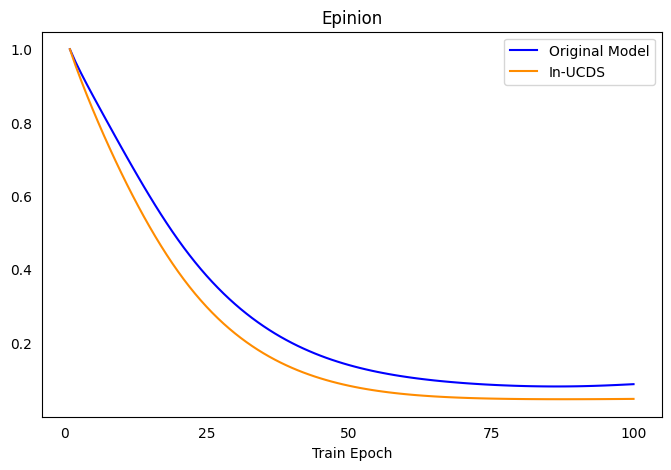

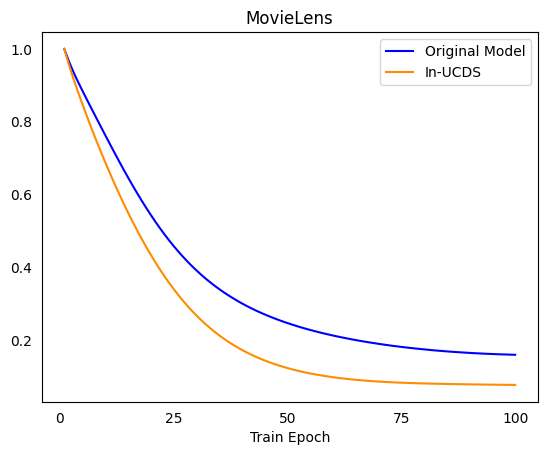

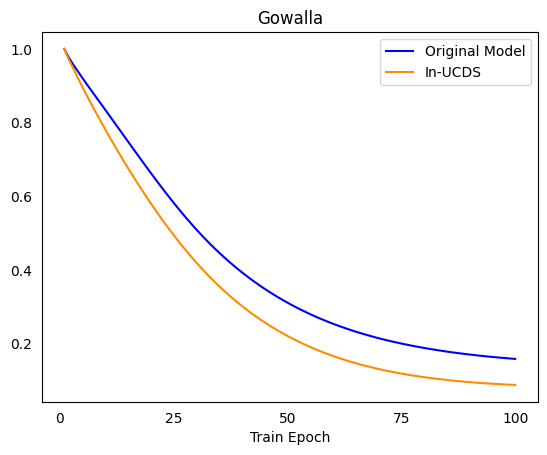

In [16]:
# 创建8x5英寸大小的图形
plt.figure(figsize=(8, 5))
# 遍历每个数据集
for dataset_name in datasets:
    # 获取当前数据集的原始模型损失值
    original_loss = loss_values[dataset_name]['original']
    # 获取当前数据集的公平模型损失值
    fair_loss = loss_values[dataset_name]['fair']
    # 对损失值进行归一化处理（除以最大值）
    original_loss_normalized = original_loss / np.max(original_loss)
    fair_loss_normalized = fair_loss / np.max(fair_loss)
    # 绘制原始模型的归一化损失曲线（蓝色）
    plt.plot(range(1, args['epochs'] + 1), original_loss_normalized, 
             color='blue', label='Original Model')
    # 绘制公平模型(In-UCDS)的归一化损失曲线（深橙色）
    plt.plot(range(1, args['epochs'] + 1), fair_loss_normalized, 
             color='darkorange', label='In-UCDS')
    # 设置图表标题为当前数据集名称
    plt.title(f'{dataset_name}')
    # 设置X轴标签
    plt.xlabel('Train Epoch')
    # 显示图例
    plt.legend()
    # 禁用网格线
    plt.grid(False)
    # 设置X轴刻度位置
    plt.xticks([0, 25, 50, 75, 100])
    # 设置Y轴刻度位置
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
    # 自定义刻度标记样式（禁用所有方向的刻度线）
    plt.tick_params(axis='both', which='both', 
                    bottom=False, top=False, 
                    left=False, right=False)
    # 将图表保存为PNG文件（以数据集命名）
    plt.savefig(f"{dataset_name}.png")
    # 显示当前图表
    plt.show()